In [126]:
import pandas as pd
import numpy as np
import itertools as it
import ipywidgets.widgets as wdg
from IPython.display import display
from ipywidgets.widgets import interact
from ipywidgets.widgets import interactive
from IPython.display import YouTubeVideo, Image
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

# The role of Python in the Oil and Gas industry

Giuseppe Pagliuca - <i>giuseppe.pagliuca@shell.com</i> 

Flow Assurance engineer - Shell Projects and Technology, Amsterdam

PyData Amsterdam - 12/13 March 2016

<i>[Notebook and the data available on GitHub][pydata]</i>

[pydata]: https://github.com/gpagliuca/pydata

The Oil and Gas world deals with complex problems that involves big data, the big data we manage is often difficult to process (e.g. due to missing data, outliers, etc.)

This talk is meant to:

* Share the typical encountered data problems

* Give examples on currently used methods involving Python

* Stimulate sharing of ideas and possible collaborations

## Introduction

## Appomatox - Subsea production facilities

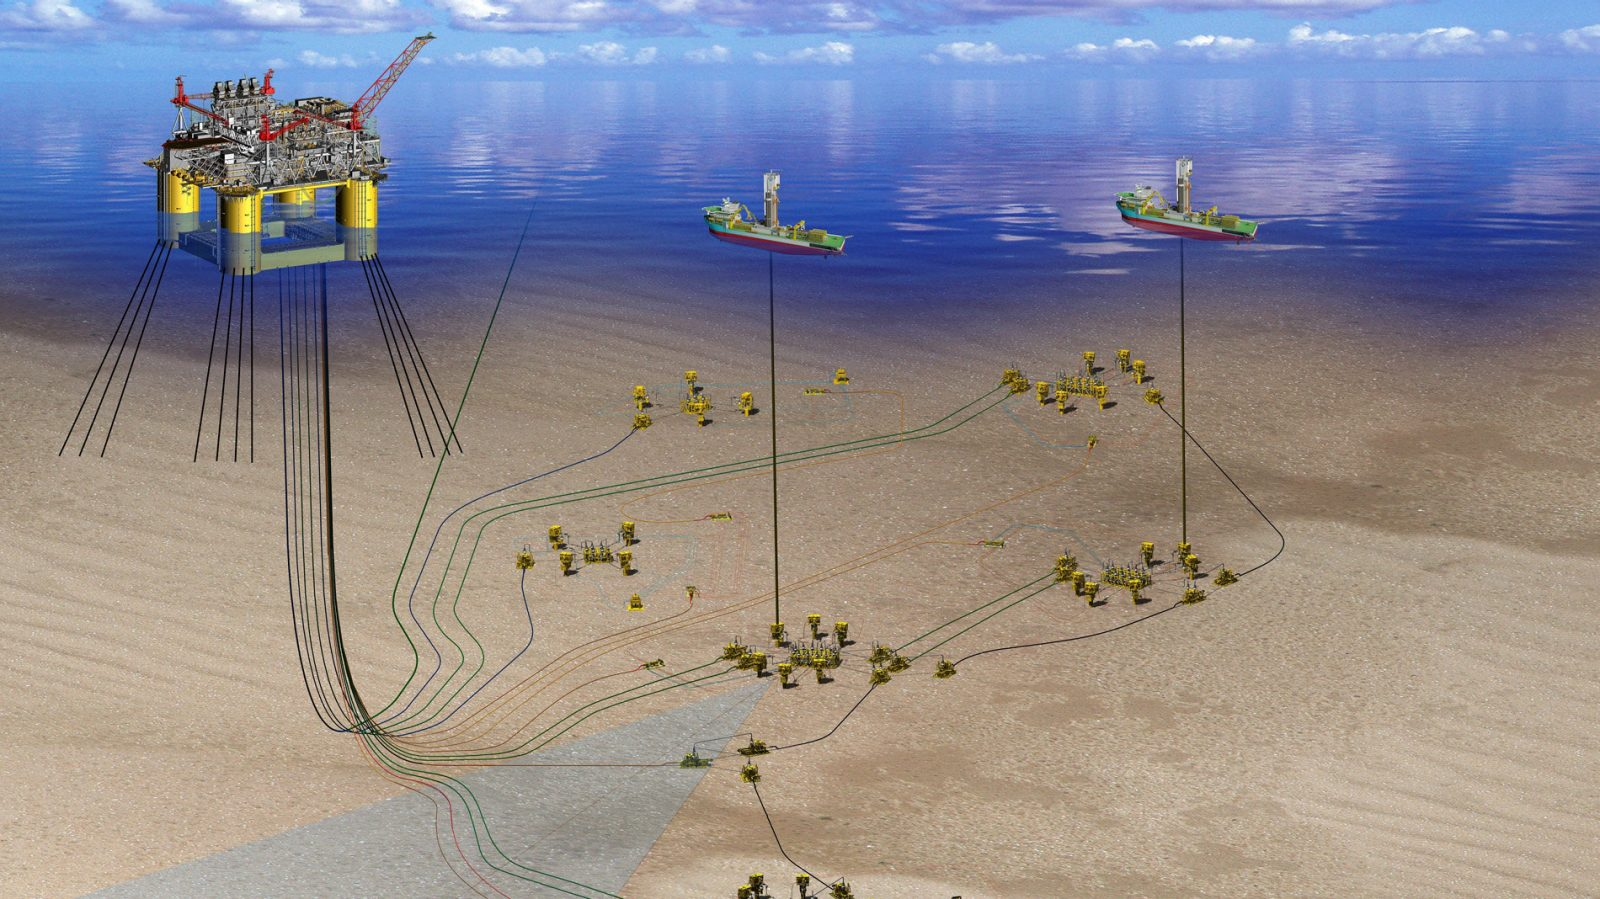

In [127]:
Image('./images/app.jpeg')

## The Shell Prelude vessel for Floating LNG 

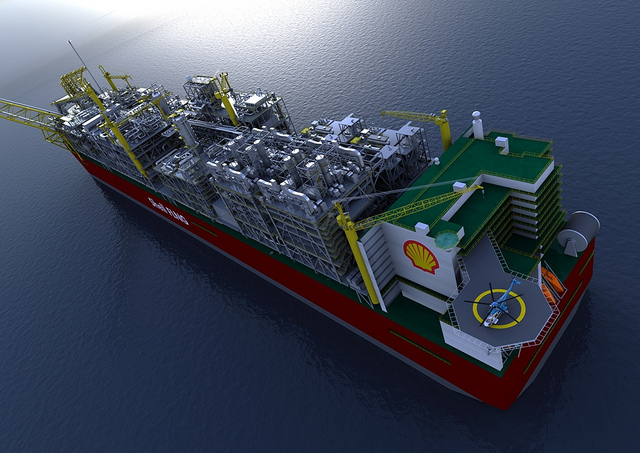

In [128]:
Image('./images/prelude.jpg')

## Off-shore platform for oil and gas production

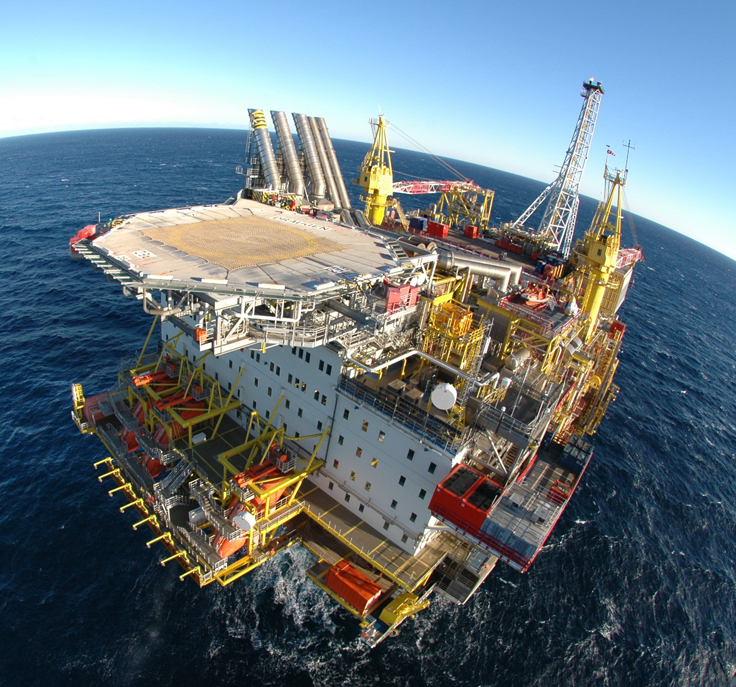

In [129]:
Image('./images/plt.jpg')

## Control room at production platform

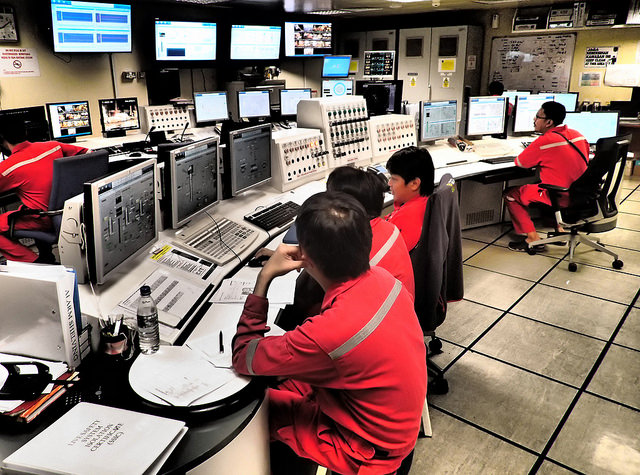

In [130]:
Image('./images/control_room.jpg')

* [Slugging][SL] - We deal with <b>unstable</b> flow!

[SL]: http://www.piping-designer.com/Flow_Regime#Slug_Flow

In [131]:
YouTubeVideo("AmMjGHK6Cfc")

---

## Outline

* [I/O data check](#link_0) - The first rule of the data club is...

* [Design case](#link_1) - A <i>simple</i> design case

* [Field case - Slugging pipeline](#link_2) - Slugging analysis

* [Field case - Gas condensate network](#link_3) - Measured vs. and simulated data 

* [Conclusions](#link_4)

* [References](#link_)


---

<a id='link_0'></a>

# I/O data check

Generally at the beginning of a new study you receive a some data from other departments/companies.  
A check on what you get and on the results of your simulations is essential: <b>garbage in = garbage out</b>.

For my day-by-day work I wrote a library called [pyfas][pyfas]

[pyfas]: https://github.com/gpagliuca/pyfas

In [132]:
tab_data = pd.read_csv("./data/tab_data/tab_data.csv")
tab_data.columns = ['Temperature', 'Pressure', 'Liquid density']
tab_data.head()

,Temperature,Pressure,Liquid density
0,-10,0.10000,899.718
1,-10,1.01325,900.424
2,-10,7.38958,901.309
3,-10,14.67920,902.434
4,-10,21.96880,903.838


In [133]:
def d3plot(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data["Temperature"], data["Pressure"], 
               data["Liquid density"])
    ax.set_xlabel('Temperature [C]', fontsize=12)
    ax.set_ylabel('Pressure [Bara]', fontsize=12)
    ax.set_zlabel('Liquid Density [kg/m3]', fontsize=12)
    plt.show()

Thanks to python and to matplotlib we can visualize possible outliers in the input thermodynamic data...

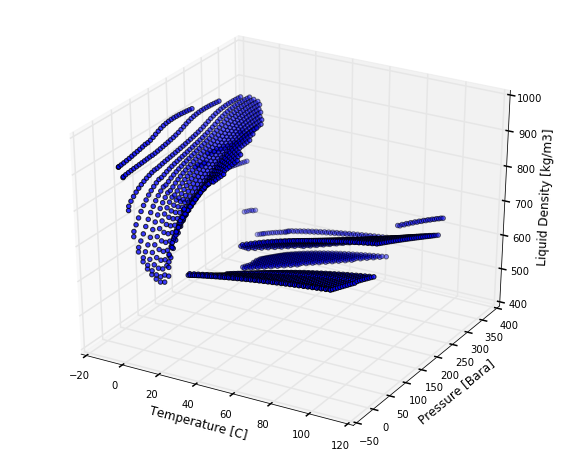

In [134]:
%matplotlib inline
d3plot(tab_data)

> Is this a good fluid model?

... or visualize the output results:

In [135]:
X_pt = np.loadtxt('./data/ppl_plot/X_pt.txt')
Y_pt = np.loadtxt('./data/ppl_plot/Y_pt.txt')
X_max_p, Y_max_p = np.loadtxt('./data/ppl_plot/max_pressure.txt', unpack=True)
TS_RANGE=10 

def ppl_plot(ts=0):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    p0, = ax1.plot(X_max_p, Y_max_p, '--r')
    p1, = ax1.plot(X_pt/1000, Y_pt[ts]/1e5)
    ax1.set_ylim(120, 160)
    ax1.set_xlim(0, 105)
    ax1.set_xlabel('X [km]', fontsize=16)
    ax1.set_ylabel('Pressure', fontsize=16)
    p2, = ax1.plot((),(), ' ')  
    plt.legend((p0, p1, p2,), ('Max Pressure', 'Pressure', 
                'Timestep = {} s'.format(round(TS_RANGE*ts, 2))),
                loc=2, ncol=3)
    plt.tick_params(axis='both', labelsize=16)
    plt.title('Packing simulation', size=20)

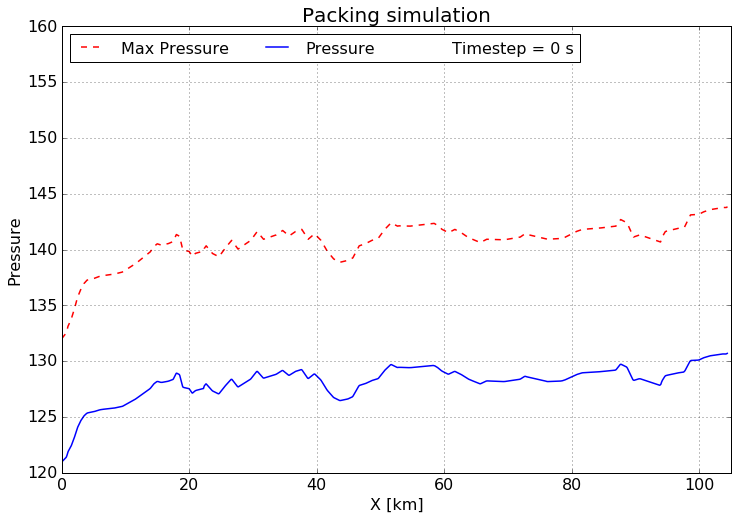

In [136]:
v = interactive(ppl_plot, ts=(0, len(Y_pt)-1))
display(v)

<a id='link_1'></a>

# Simple design case - Pipeline sizing

> You, as flow assurance engineer, are requested to determine the <b>pipeline diameter</b> and the required <b>thermal insulation</b> for a single pipeline.

> Easy... or not?

## Let's have a look on what we got...

In [137]:
geo = pd.read_excel("./data/design_case/geometry.xlsx")

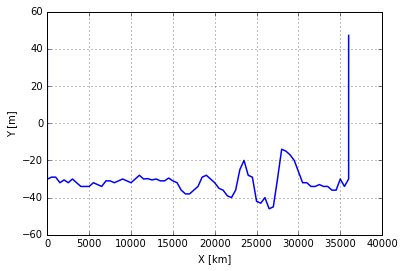

In [138]:
%matplotlib inline
plt.xlabel(geo.keys()[0])
plt.ylabel(geo.keys()[1])
plt.plot(geo[geo.keys()[0]], geo[geo.keys()[1]]);

> It looks OK... or not?

## OK, I checked my data, what's next?

Now it is time to simulate:

* several flowrates
* 3 diameters
* 2 insulations
* 2 ambient temperatures
* 2 fluid temperature

<b>Cases to simulate = 792!</b>

In [139]:
nominal_flow = 100
WCs = (1000, 5000) 
T_ambients = (5, 15)
flowrates = np.arange(0.2, 1.3, 0.1) * nominal_flow
n_diameter = (16, 18, 20)
n_insulation = (4, 20, 80)
n_inlet_T = (60, 80)
case_variables = (WCs, T_ambients, flowrates, n_diameter, n_insulation,
                  n_inlet_T)
n_cases = np.prod(np.array([len(x) for x in case_variables]))
print("Cases to simulate = {}".format(n_cases))

Cases to simulate = 792


To generate all the combinations we can use product from itertools:

In [140]:
cases = {}
for idx, case in enumerate(it.product(*case_variables)):
    cases[idx] = case
cases_df = pd.DataFrame(cases, index=("WC", "T_amb", 
                                     "Flowrate", "diameter",
                                     "OHTC", "inlet_T")).T

cases_df.head()

,WC,T_amb,Flowrate,diameter,OHTC,inlet_T
0,1000,5,20,16,4,60
1,1000,5,20,16,4,80
2,1000,5,20,16,20,60
3,1000,5,20,16,20,80
4,1000,5,20,16,80,60


In [141]:
cases_df.to_csv("../design case/cases.csv", index=False)

## Data Processing 

In [142]:
P_in, T_out, LIQC = np.loadtxt("./data/design_case/sim_results.txt", 
                               usecols=(1, 2, 3), unpack=True)

cases_df["P_in"] = P_in
cases_df["T_out"] = T_out
cases_df["LIQC"] = LIQC

P_in_bc, T_out_bc, LIQC_bc = np.loadtxt("./data/design_case/sim_results_bc.txt", 
                               usecols=(1, 2, 3), unpack=True)

P_in_16, T_out_16, LIQC_16 = np.loadtxt("./data/design_case/sim_results_16.txt", 
                               usecols=(1, 2, 3), unpack=True)

P_in_20, T_out_20, LIQC_20 = np.loadtxt("./data/design_case/sim_results_20.txt", 
                               usecols=(1, 2, 3), unpack=True)

flowrates = np.arange(0.2, 1.3, 0.05)*100

In [143]:
def g0():
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.tick_params(axis='both', labelsize=16)
    ax1.plot(cases_df.Flowrate, cases_df.P_in, ".")
    p0, = ax1.plot(flowrates, P_in_bc, '-g')
    p2, = ax1.plot(flowrates, P_in_16, '-*g')
    p3, = ax1.plot(flowrates, P_in_20, '-^g')     
    plt.legend((p0, p2, p3), ('18"', '16"', '20"'),
               loc=2, ncol=3)
    ax1.set_xlim(15, 125)
    ax1.set_xlabel("Flowrate [%]", fontsize=16)
    ax1.set_ylabel("Inlet Pressure", fontsize=16)
    plt.show()

def g1():
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.tick_params(axis='both', labelsize=16)
    ax1.plot(cases_df.Flowrate, cases_df.T_out, ".")
    p0, = ax1.plot(flowrates, T_out_bc, '-g')
    p2, = ax1.plot(flowrates, T_out_16, '-*g')
    p3, = ax1.plot(flowrates, T_out_20, '-^g')
    plt.legend((p0, p2, p3), ('18"', '16"', '20"'),
               loc=2, ncol=3)
    ax1.set_xlim(15, 125)
    ax1.set_xlabel("Nominal flowrate [%]", fontsize=16)
    ax1.set_ylabel("Outlet Temperature", fontsize=16)

def g2():
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.tick_params(axis='both', labelsize=16)
    ax1.plot(cases_df.Flowrate, cases_df.LIQC, ".")
    p0, = ax1.plot(flowrates, LIQC_bc, '-g')
    p2, = ax1.plot(flowrates, LIQC_16, '-*g')
    p3, = ax1.plot(flowrates, LIQC_20, '-^g')
    plt.legend((p0, p2, p3), ('18"', '16"', '20"'),
               loc=2, ncol=3)
    ax1.set_xlim(15, 125)
    ax1.set_xlabel("Nominal flowrate [%]", fontsize=16)
    ax1.set_ylabel("Liquid inventory", fontsize=16)

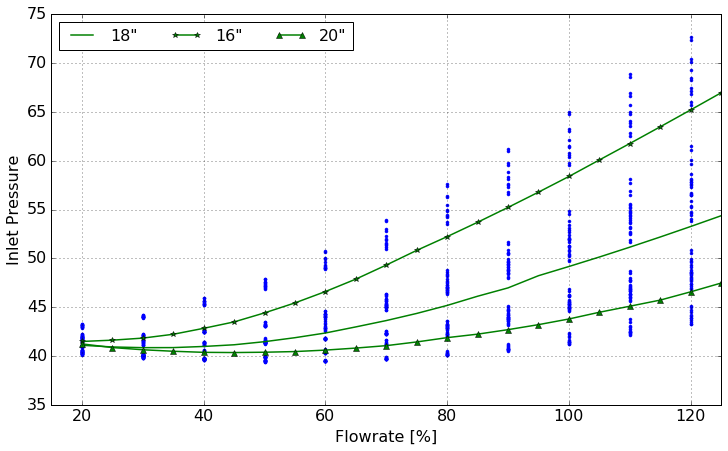

In [144]:
%matplotlib inline
g0();

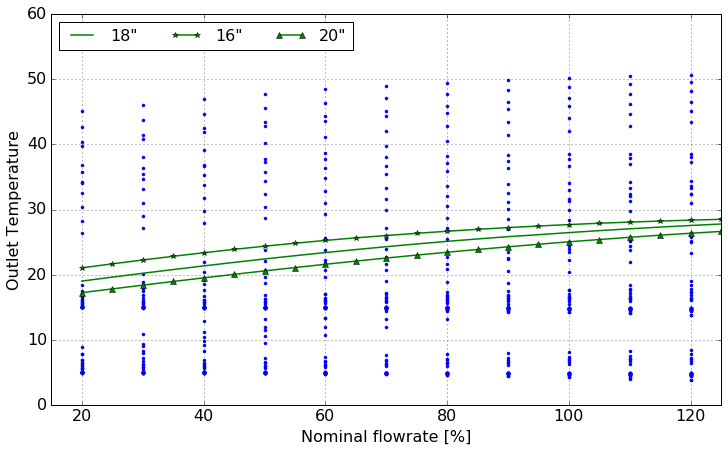

In [145]:
%matplotlib inline
g1();

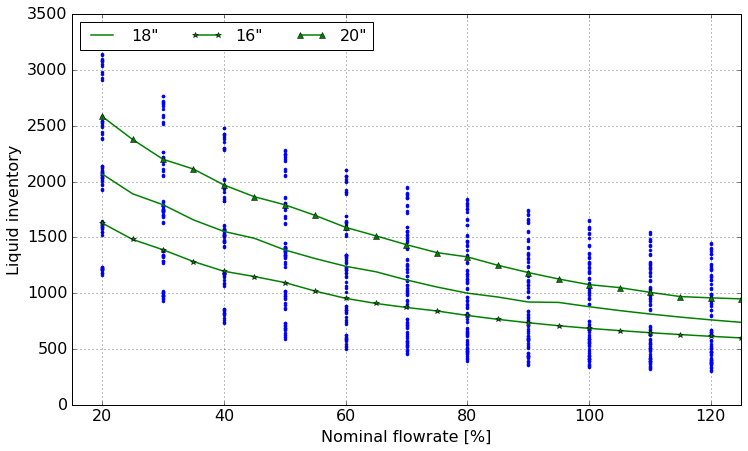

In [146]:
%matplotlib inline
g2();

---

<a id='link_2'></a>

# Slugging pipeline - A real case from Iraq

## Introduction 

Starting from field data we have to identify the slugging frequency of an existing pipeline

## Exploratory Data Analysis

Two datasets available, some days of liquid production each with a sampling rate of 86 seconds.

In [147]:
t1, fl1 = np.loadtxt("./data/iraq_case/week_1.txt", unpack=True)
t2, fl2 = np.loadtxt("./data/iraq_case/week_2.txt", unpack=True)

df1 = pd.DataFrame({'time': t1, 'fl': fl1})
df2 = pd.DataFrame({'time': t2, 'fl': fl2})

In [148]:
def week_1_EDA(blocks):
    plt.figure(figsize=(12,7))
    plt.plot(t1, fl1, '.')
    plt.xlabel('Time [days]', fontsize=16)
    plt.ylabel('Liquid flowrate', fontsize=16)
    plt.tick_params(axis='both', labelsize=16)

    if blocks==True:
        plt.plot((1.1, 1.1), (-200, 1400), '--r', lw=2)
        plt.plot((1.8, 1.8), (-200, 1400), '--r', lw=2)
        plt.plot((4.1, 4.1), (-200, 1400), '--r', lw=2)
        plt.plot((5, 5), (-200, 1400), '--r', lw=2)
        plt.text(1.38, 200, 'B0', size=15, bbox = dict(boxstyle="square", 
                                                       ec=(1., 0.5, 0.5), 
                                                       fc=(1., 0.8, 0.8),))
        plt.text(4.5, 200, 'B1', size=15, bbox = dict(boxstyle="square", 
                                                       ec=(1., 0.5, 0.5), 
                                                       fc=(1., 0.8, 0.8),))
        
def week_2_EDA(blocks):
    plt.figure(figsize=(12,7))
    plt.plot(t2, fl2, '.')
    plt.xlabel('Time [days]', fontsize=16)
    plt.ylabel('Liquid flowrate', fontsize=16)
    plt.tick_params(axis='both', labelsize=16)

    if blocks==True:
        plt.plot((1.5, 1.5), (0, 1800), '--r', lw=2)
        plt.plot((2.5, 2.5), (0, 1800), '--r', lw=2)
        plt.plot((3.1, 3.1), (0, 1800), '--r', lw=2)
        plt.plot((4, 4), (0, 1800), '--r', lw=2)
        plt.text(2, 200, 'B2', size=15, bbox = dict(boxstyle="square", 
                                                       ec=(1., 0.5, 0.5), 
                                                       fc=(1., 0.8, 0.8),))
        plt.text(3.5, 200, 'B3', size=15, bbox = dict(boxstyle="square", 
                                                       ec=(1., 0.5, 0.5), 
                                                       fc=(1., 0.8, 0.8),))

## Week 1

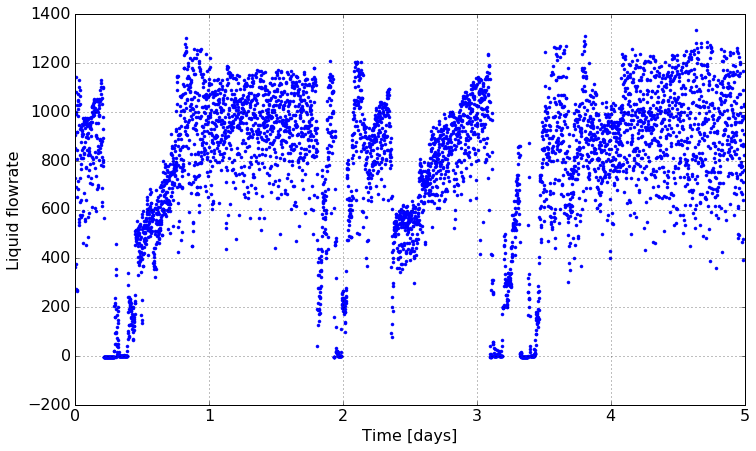

In [149]:
interact(week_1_EDA, blocks=False);

## Week 2

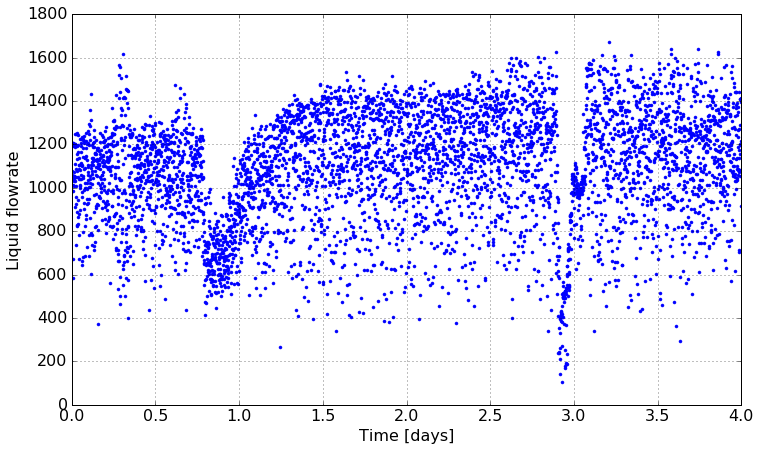

In [150]:
interact(week_2_EDA, blocks=False); 

## Data processing

In [151]:
dt = 1/((t1[1] - t1[0])*(24*3600))

def block_plot(t_i, t_f, dataframe):
    data = df[df["time"] >= t_i]
    data = data[data["time"] <= t_f]
    data['fl'].describe()
    data['fl'] = data['fl'] - data['fl'].mean()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(data['time'], data['fl'])
    signal = np.fft.fft(data.fl)
    freqs = np.fft.fftfreq(len(signal))
    f_rate = dt
    freq_in_hertz=abs(freqs*f_rate)
    ax1.set_title('Signal')
    ax2.plot(freq_in_hertz, abs(signal**2))
    ax2.set_title('FT')
    plt.grid(True)
    plt.xlabel('Frequency [Hz]')
    return round(1/freq_in_hertz[np.argmax(np.abs(signal)**2)]/60, 1)

## Block B0

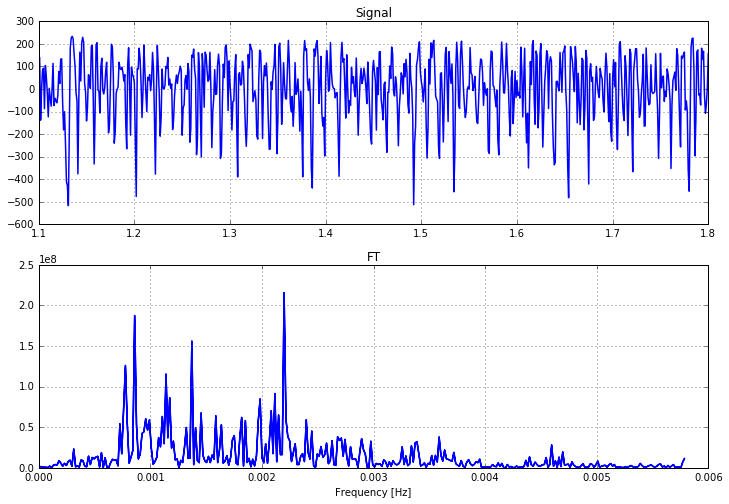

In [152]:
initial_time = 1.1
final_time = 1.8
df = df1
f0 = block_plot(initial_time, final_time, df)

## Block B1

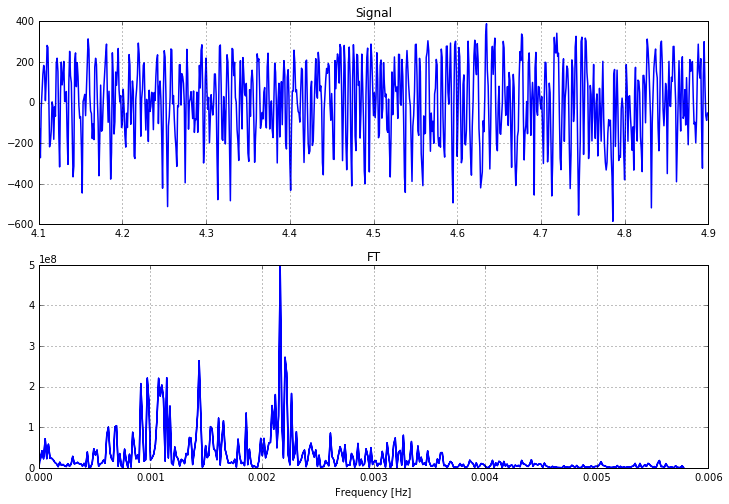

In [153]:
initial_time = 4.1
final_time = 4.9
df = df1
f1 = block_plot(initial_time, final_time, df)

## Block B2

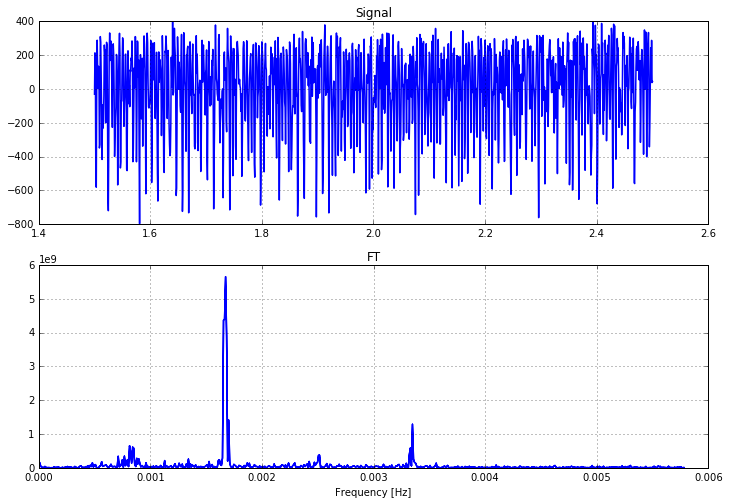

In [154]:
initial_time = 1.5
final_time = 2.5
df = df2
f2 = block_plot(initial_time, final_time, df)

## Block B3

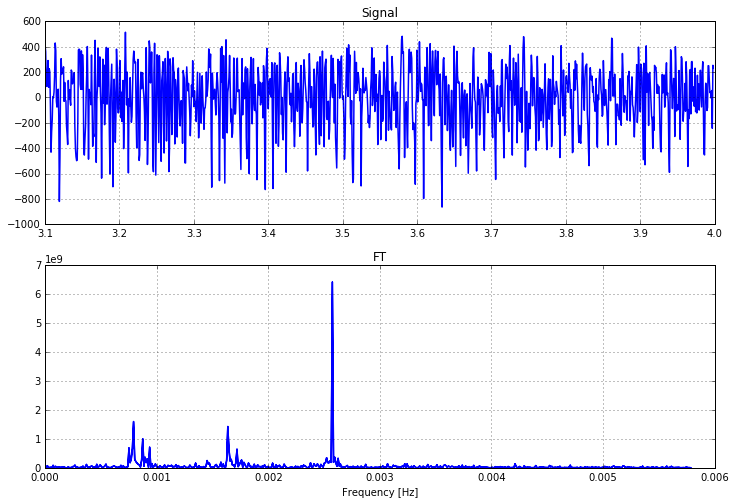

In [155]:
initial_time = 3.1
final_time = 4
df = df2
f3 = block_plot(initial_time, final_time, df)

## Frequency

In [156]:
pd.DataFrame({'Frequency [1/min]': (f0, f1, f2, f3)}, 
             index=("B0", "B1", "B2", "B3"))

,Frequency [1/min]
B0,7.6
B1,7.7
B2,10.0
B3,6.5


> Was the sampling rate good enough?

---

<a id='link_3'></a>

# Gas condensate network

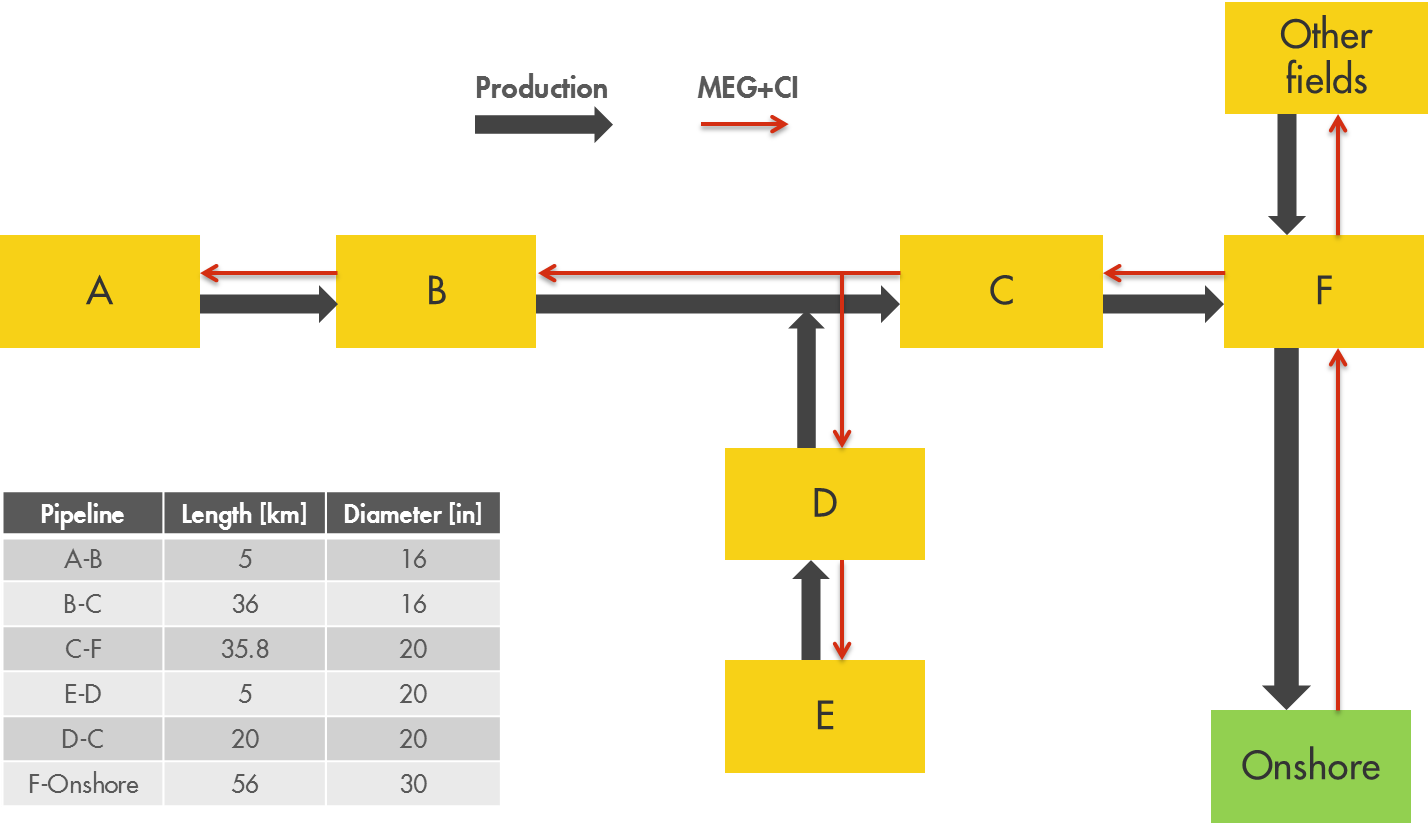

In [157]:
Image('./images/network_ex2.png')

This system is difficult to model: 

* no steady state starting point 
* limited information available per well
* liquid measurements only in F and Onshore

Because of the missing field data, it was decided to build a transient fluid dynamic model of the offshore facilities connected with the production database. 

The connection with the production database periodically retrieves field data:

1. This serve as input to the model  (e.g. the inlet gas flows)
2. This can be used for model/field comparison (e.g. system inlet pressure)

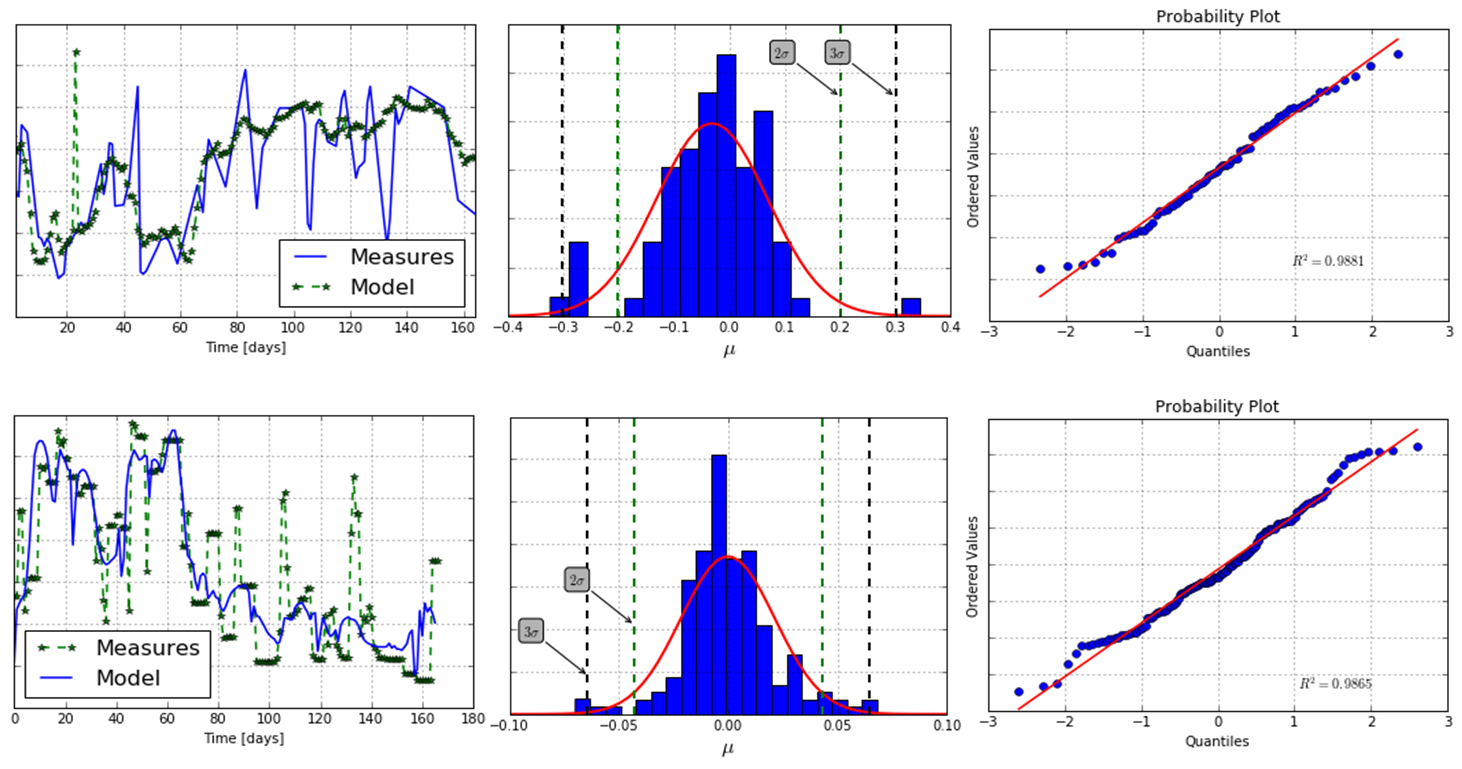

In [158]:
Image('./images/physical_model.png')

> Is this good enough?  

All the models have their limitations, but this one was proven to be useful. This model is the-state-of-the-art of what you can obtain with a physical model.

But at the same time the basic model is not always accurate and some compromises were made to increase the computational speed of the model.

> How can we improve the modelling approach? There still is a lot of data available that was not yet used the physical model.

Possible <i>quick</i> implementations:

* Automatic water from wells tuning

* Alternative monitoring tool using virtual metering

* Hybrid model (ann + physical model)?

---

<a id='link_4'></a>

# Conclusions (1/2)

* Proper pre and post processing of data (both field data and model data) can provide huge benefits to the oil and gas industry. 

* Python helps to shorten pre and post processing steps; Easy to re-analyze issues with automatic procedures

* Even a <i>basic</i> design cases may require hundreds of simulations, and automated handling can play a key role in the management of this information.

# Conclusions (2/2)

* The Oil and Gas industry has a long and strong tradition of physical modelling. New opportunities (though currently still exotic) are machine learning and artificial neural networks.

* Petabytes of field data are available in oil and gas production, but they are barely used: this gives many opportunities for data specialists to improve field operations.

---

<a id='link_5'></a>

# References


* [talk][pydata]
* [pyfas][pyfas]

[pyfas]: https://github.com/gpagliuca/pyfas
[pydata]: https://github.com/gpagliuca/pydata.git

# Questions?

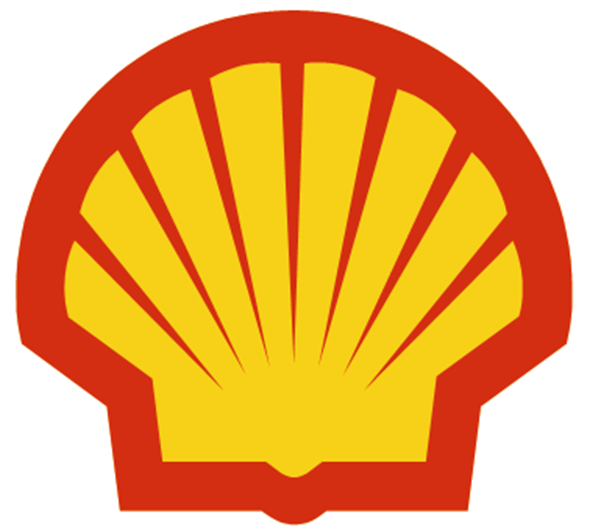

In [159]:
Image('./images/logo.png')